## Discrete Anomaly Detection Exercises

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from env import get_db_url

In [4]:
query = 'SELECT * FROM api_access'
df = pd.read_sql(query, get_db_url('logs') )

In [5]:
df.head()

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [6]:
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [7]:
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [8]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

In [9]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')


In [10]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [13]:
df.shape

(13978, 8)

---

All the same value for 'request_method'

In [12]:
df.request_method.value_counts(dropna=False)

GET    13978
Name: request_method, dtype: int64

---

Explore 'size_mb'

In [16]:
df.size_mb.describe()

count    13978.000000
mean         0.429155
std          0.154010
min          0.000000
25%          0.477445
50%          0.486506
75%          0.487605
max          1.961066
Name: size_mb, dtype: float64

In [18]:
df[df['size_mb'] > 0.50]

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591
2019-04-19 19:42:41,97.105.19.58,GET,/api/v1/sales?page=79/,HTTP/1.1,200,2056327,python-requests/2.21.0,1.961066


In [20]:
df[df['size_mb'] == 0.00]

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:55:15,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.20.1,0.0
2019-04-16 19:56:02,97.105.19.58,GET,/api/v1/sales?page=21,HTTP/1.1,499,0,python-requests/2.20.1,0.0
2019-04-16 20:28:46,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.0
2019-04-16 20:33:24,97.105.19.58,GET,/api/v1/sales?page=29,HTTP/1.1,499,0,python-requests/2.21.0,0.0
2019-04-16 20:38:13,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0
2019-04-16 20:38:55,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0
2019-04-16 20:39:00,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0
2019-04-16 20:45:17,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0
2019-04-16 20:45:28,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.0


---

All 'http_version' are the same value

In [21]:
df.http_version.value_counts()

HTTP/1.1    13978
Name: http_version, dtype: int64

---

Explore 'user_agent'

In [27]:
df.user_agent.value_counts(normalize=True)

python-requests/2.21.0                                                                                                       0.858850
python-requests/2.20.1                                                                                                       0.136715
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.002432
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                           0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                   0.000501
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                 0.000429
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.000286
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/53

<AxesSubplot:>

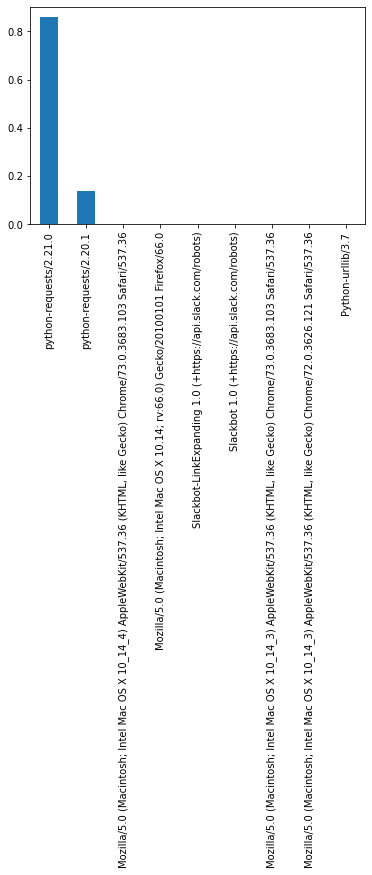

In [67]:
df.user_agent.value_counts(normalize=True).plot(kind='bar')

---

In [34]:
user_agent_df = pd.DataFrame(df.user_agent.value_counts(normalize=True).reset_index().rename(columns={'index': 'user_agent', 'user_agent': 'proba'}))
user_agent_df.sort_values(by='proba')
                             

,user_agent,proba
8,Python-urllib/3.7,0.000072
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000143
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000286
5,Slackbot 1.0 (+https://api.slack.com/robots),0.000429
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000501
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000572
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002432
1,python-requests/2.20.1,0.136715
0,python-requests/2.21.0,0.858850


---

In [41]:
ua1 = df[df['user_agent'] == 'Python-urllib/3.7']
ua1

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 20:57:38,97.105.19.58,GET,/api/v1/items&page=0,HTTP/1.1,200,162,Python-urllib/3.7,0.000154


In [42]:
ua2 = df[df['user_agent'] == 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36']
ua2

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 01:25:07,70.121.214.34,GET,/,HTTP/1.1,200,42,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000040
2019-04-17 01:25:07,70.121.214.34,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000154


In [43]:
ua3 = df[df['user_agent'] == 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36']
ua3

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 21:49:21,97.105.19.58,GET,/,HTTP/1.1,200,42,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000040
2019-04-16 21:49:22,97.105.19.58,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000154
2019-04-17 02:18:07,72.181.113.170,GET,/,HTTP/1.1,200,42,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000040
2019-04-17 02:18:07,72.181.113.170,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000154


In [58]:
ua3.ip.value_counts()

97.105.19.58      2
72.181.113.170    2
Name: ip, dtype: int64

In [44]:
ua4 = df[df['user_agent'] == 'Slackbot 1.0 (+https://api.slack.com/robots)']
ua4

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:39:15,52.90.165.200,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-16 19:40:33,34.207.64.242,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-16 19:40:37,34.229.70.250,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-16 21:22:22,54.145.52.184,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-16 21:38:57,35.174.209.2,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-17 02:14:28,52.87.230.102,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154


In [57]:
ua4.ip.value_counts()

52.90.165.200    1
34.207.64.242    1
34.229.70.250    1
54.145.52.184    1
35.174.209.2     1
52.87.230.102    1
Name: ip, dtype: int64

In [45]:
ua5 = df[df['user_agent'] == 'Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)']
ua5

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:39:14,3.92.201.136,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040
2019-04-16 19:40:32,3.88.129.158,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.003396
2019-04-16 19:40:36,54.172.14.223,GET,/api/v1/,HTTP/1.1,200,162,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000154
2019-04-16 21:22:22,35.175.171.137,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040
2019-04-16 21:22:23,52.87.230.102,GET,/api/v1/sales,HTTP/1.1,200,493905,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.471025
2019-04-16 21:38:57,35.175.171.137,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.003396
2019-04-17 02:14:27,52.91.30.150,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040


In [56]:
ua5.ip.value_counts()

35.175.171.137    2
3.92.201.136      1
3.88.129.158      1
54.172.14.223     1
52.87.230.102     1
52.91.30.150      1
Name: ip, dtype: int64

In [46]:
ua6 = df[df['user_agent'] == 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0']
ua6

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 01:25:07,72.181.105.81,GET,/,HTTP/1.1,200,42,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000040
2019-04-17 01:25:21,72.181.105.81,GET,/documentation,HTTP/1.1,200,348,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000332
2019-04-17 01:33:06,72.181.105.81,GET,/api/v1/items?page=2,HTTP/1.1,200,3659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.003489
2019-04-17 01:33:19,72.181.105.81,GET,/api/v1/items?page=3,HTTP/1.1,200,1787,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.001704
2019-04-17 01:33:32,72.181.105.81,GET,/api/v1/items?page=4,HTTP/1.1,200,48,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000046
2019-04-17 01:56:33,72.181.105.81,GET,/api/v1/stores,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.001266
2019-04-17 01:56:57,72.181.105.81,GET,/api/v1/sales,HTTP/1.1,200,493905,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.471025
2019-04-17 02:07:44,72.181.105.81,GET,/api/v1/sales,HTTP/1.1,200,493905,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.471025


In [55]:
ua6.ip.value_counts()

72.181.105.81    8
Name: ip, dtype: int64

In [48]:
ua7 = df[df['user_agent'] == 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36']
ua7.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:38:16,97.105.19.58,GET,/api/V1/HiZach!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154
2019-04-16 19:38:16,97.105.19.58,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154
2019-04-16 19:44:04,97.105.19.58,GET,/api/v1/stores?page=0,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.001266
2019-04-16 19:44:04,97.105.19.58,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154
2019-04-16 19:44:16,97.105.19.58,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.001266


In [51]:
ua7.ip.value_counts()

97.105.19.58     26
72.181.105.81     8
Name: ip, dtype: int64

In [49]:
ua8 = df[df['user_agent'] == 'python-requests/2.20.1']
ua8

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:40:38,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,200,494819,python-requests/2.20.1,0.471896
2019-04-16 19:40:43,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,200,494819,python-requests/2.20.1,0.471896
2019-04-16 19:42:01,97.105.19.58,GET,/api/v1/sales?page=183,HTTP/1.1,200,308243,python-requests/2.20.1,0.293963
2019-04-16 19:42:08,97.105.19.58,GET,/api/v1/sales?page=183,HTTP/1.1,200,308243,python-requests/2.20.1,0.293963
2019-04-16 19:46:47,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,200,494819,python-requests/2.20.1,0.471896
...,...,...,...,...,...,...,...,...
2019-04-16 21:36:39,97.105.19.58,GET,/api/v1/sales?page=179,HTTP/1.1,200,511963,python-requests/2.20.1,0.488246
2019-04-16 21:36:42,97.105.19.58,GET,/api/v1/sales?page=180,HTTP/1.1,200,510788,python-requests/2.20.1,0.487125
2019-04-16 21:36:44,97.105.19.58,GET,/api/v1/sales?page=181,HTTP/1.1,200,510317,python-requests/2.20.1,0.486676


In [50]:
ua8.ip.value_counts()

97.105.19.58    1911
Name: ip, dtype: int64

In [53]:
ua9 = df[df['user_agent'] == 'python-requests/2.21.0']
ua9.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [54]:
ua9.ip.value_counts()

97.105.19.58      10059
173.173.113.51     1059
72.181.113.170      611
72.181.105.81       230
68.201.219.223       21
24.26.242.9          21
45.23.250.16          1
95.31.18.119          1
95.31.16.121          1
97.105.15.120         1
Name: ip, dtype: int64

---

In [59]:
ua1.ip.isin(ua9.ip)

timestamp
2019-04-16 20:57:38    True
Name: ip, dtype: bool

In [60]:
ua2.ip.isin(ua9.ip)

timestamp
2019-04-17 01:25:07    False
2019-04-17 01:25:07    False
Name: ip, dtype: bool

In [61]:
ua3.ip.isin(ua9.ip)

timestamp
2019-04-16 21:49:21    True
2019-04-16 21:49:22    True
2019-04-17 02:18:07    True
2019-04-17 02:18:07    True
Name: ip, dtype: bool

In [62]:
ua4.ip.isin(ua9.ip)

timestamp
2019-04-16 19:39:15    False
2019-04-16 19:40:33    False
2019-04-16 19:40:37    False
2019-04-16 21:22:22    False
2019-04-16 21:38:57    False
2019-04-17 02:14:28    False
Name: ip, dtype: bool

In [63]:
ua5.ip.isin(ua9.ip)

timestamp
2019-04-16 19:39:14    False
2019-04-16 19:40:32    False
2019-04-16 19:40:36    False
2019-04-16 21:22:22    False
2019-04-16 21:22:23    False
2019-04-16 21:38:57    False
2019-04-17 02:14:27    False
Name: ip, dtype: bool

In [64]:
ua6.ip.isin(ua9.ip)

timestamp
2019-04-17 01:25:07    True
2019-04-17 01:25:21    True
2019-04-17 01:33:06    True
2019-04-17 01:33:19    True
2019-04-17 01:33:32    True
2019-04-17 01:56:33    True
2019-04-17 01:56:57    True
2019-04-17 02:07:44    True
Name: ip, dtype: bool

In [65]:
ua7.ip.isin(ua9.ip)

timestamp
2019-04-16 19:38:16    True
2019-04-16 19:38:16    True
2019-04-16 19:44:04    True
2019-04-16 19:44:04    True
2019-04-16 19:44:16    True
2019-04-16 19:44:16    True
2019-04-16 19:44:24    True
2019-04-16 19:44:24    True
2019-04-16 19:44:28    True
2019-04-16 19:44:28    True
2019-04-16 19:44:38    True
2019-04-16 19:44:38    True
2019-04-16 19:45:20    True
2019-04-16 19:45:20    True
2019-04-16 19:49:41    True
2019-04-16 19:49:43    True
2019-04-16 19:49:51    True
2019-04-16 19:49:53    True
2019-04-16 19:49:58    True
2019-04-16 19:49:58    True
2019-04-16 19:59:46    True
2019-04-16 19:59:47    True
2019-04-16 20:01:02    True
2019-04-16 20:01:03    True
2019-04-16 20:31:09    True
2019-04-16 20:31:10    True
2019-04-16 22:01:52    True
2019-04-16 22:01:52    True
2019-04-16 22:01:53    True
2019-04-16 22:01:53    True
2019-04-16 22:02:42    True
2019-04-16 22:02:42    True
2019-04-16 23:44:34    True
2019-04-16 23:44:35    True
Name: ip, dtype: bool

---

In [68]:
ua2.ip.isin(ua4.ip)

timestamp
2019-04-17 01:25:07    False
2019-04-17 01:25:07    False
Name: ip, dtype: bool

In [69]:
ua2.ip.isin(ua5.ip)

timestamp
2019-04-17 01:25:07    False
2019-04-17 01:25:07    False
Name: ip, dtype: bool

---

Explore 'request_path'

In [78]:
df.request_path.value_counts()

/api/v1/sales?page=2               709
/api/v1/items                      464
/api/v1/items?page=2               291
/api/v1/items?page=3               219
/api/v1/stores                     162
                                  ... 
/api/v1                              1
/api/v1//api/v1/items/next_page      1
/api/v1//api/v1/items                1
/api/v1/items?page=0                 1
/api/V1/HiZach!                      1
Name: request_path, Length: 220, dtype: int64

In [70]:
df.request_path.value_counts(normalize=True)

/api/v1/sales?page=2               0.050723
/api/v1/items                      0.033195
/api/v1/items?page=2               0.020818
/api/v1/items?page=3               0.015667
/api/v1/stores                     0.011590
                                     ...   
/api/v1                            0.000072
/api/v1//api/v1/items/next_page    0.000072
/api/v1//api/v1/items              0.000072
/api/v1/items?page=0               0.000072
/api/V1/HiZach!                    0.000072
Name: request_path, Length: 220, dtype: float64

<AxesSubplot:>

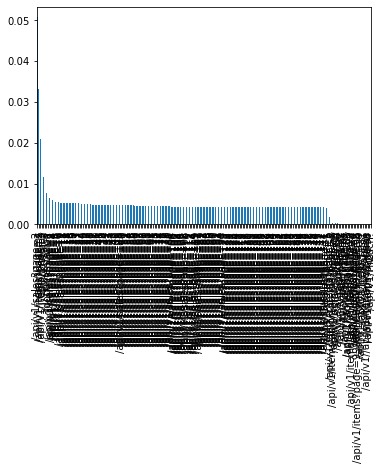

In [71]:
df.request_path.value_counts(normalize=True).plot(kind='bar')

In [72]:
df.request_path.value_counts(normalize=True).describe()

count    220.000000
mean       0.004545
std        0.004277
min        0.000072
25%        0.004221
50%        0.004364
75%        0.004668
max        0.050723
Name: request_path, dtype: float64

In [73]:
request_path_df = pd.DataFrame(df.request_path.value_counts(normalize=True).reset_index().rename(columns={'index': 'request_path', 'request_path': 'proba'}))
request_path_df.sort_values(by='proba')

,request_path,proba
219,/api/V1/HiZach!,0.000072
205,/api/v1/stores?page=666,0.000072
206,/api/v1/items/,0.000072
207,/api/v1/items/api/v1/items?page=3,0.000072
208,/api/v1/items?page=4,0.000072
...,...,...
4,/api/v1/stores,0.011590
3,/api/v1/items?page=3,0.015667
2,/api/v1/items?page=2,0.020818
1,/api/v1/items,0.033195


In [77]:
request_path_df[request_path_df['proba'] < 0.004]

,request_path,proba
192,/favicon.ico,0.001860
193,/api/v1//api/v1/items?page=2,0.000715
194,/api/v1/items/api/v1/items?page=2,0.000429
195,/api/v1/items/next_page,0.000358
196,/api/v1/stores?page=3,0.000286
197,/api/v1/,0.000286
198,/api/v1/sales?page=79/,0.000215
199,/api/v1/store,0.000215
200,/api/v1/sales/?page=2,0.000215
201,/api/v1/itemsitems,0.000215


In [75]:
request_path_df[request_path_df['proba'] < 0.00008]

,request_path,proba
205,/api/v1/stores?page=666,0.000072
206,/api/v1/items/,0.000072
207,/api/v1/items/api/v1/items?page=3,0.000072
208,/api/v1/items?page=4,0.000072
209,/api/v1/items&page=0,0.000072
210,/api/v1/stores?page=2,0.000072
211,/api/v1/items?page=99999999999999999998,0.000072
212,/api/v1/stores?page=999,0.000072
213,/api/v1/I_DIDNT_DO_IT!!!!,0.000072
214,/api/v1/helloclass!,0.000072
